In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *

In [2]:
# for four ensembles (i.e. without ml0p008, since that one was Coulomb --> Landau gf'd)
# ensembles = ['24I/ml0p005/', '24I/ml0p01/', '32I/ml0p004/', '32I/ml0p006/']
# Lats = [Lattice(24, 64), Lattice(24, 64), Lattice(32, 64), Lattice(32, 64)]
# ainv_list = [1.784, 1.784, 2.382, 2.382]    # GeV
# mpi_list = [0.3396, 0.4322, 0.3020, 0.3597]    # GeV
# δainv = np.array([0.005, 0.005, 0.008, 0.008])

# for all five ensembles
ensembles = ['24I/ml0p005/', '24I/ml0p01/', '32I/ml0p004/', '32I/ml0p006/', '32I/ml0p008/']
Lats = [Lattice(24, 64), Lattice(24, 64), Lattice(32, 64), Lattice(32, 64), Lattice(32, 64)]
ainv_list = [1.784, 1.784, 2.382, 2.382, 2.382]    # GeV
mpi_list = [0.3396, 0.4322, 0.3020, 0.3597, 0.4108]    # GeV
δainv = np.array([0.005, 0.005, 0.008, 0.008, 0.008])

a_list = [hbarc / ainv for ainv in ainv_list]
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv_list[i] for i in range(n_ens)]
δa = hbarc / (np.array(ainv_list) ** 2) * δainv

# colors = ['r', 'b', 'c', 'g']

file_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma.h5' for ens in ensembles]
Fs = [h5py.File(fpath, 'r') for fpath in file_paths]
k_list = [f['momenta'][()] for f in Fs]
mom_list = [[Lats[i].to_linear_momentum(k, datatype=np.float64) for k in k_list[i]] for i in range(n_ens)]
mu_list = [np.array([get_energy_scale(q, a_list[i], Lats[i]) for q in k_list[i]]) for i in range(n_ens)]
Zq_list = [np.real(f['Zq'][()]) for f in Fs]
n_momenta, n_boots = [Zq.shape[0] for Zq in Zq_list], [Zq.shape[1] for Zq in Zq_list]
ZV_list = [np.real(f['ZV'][()]) for f in Fs]
ZA_list = [np.real(f['ZA'][()]) for f in Fs]
Z_list = []
for idx in range(n_ens):
    Z = np.zeros((5, 5, n_momenta[idx], n_boots[idx]), dtype = np.float64)
    f = Fs[idx]
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(f[key][()])
    Z_list.append(Z)

In [3]:
# # read out chiral extrap data
# n_spacings = 2
# n_ens_sp = 2    # 2 ensembles per lattice spacing
# n_mom = n_momenta[0]
# Lat_24I = Lattice(24, 64)
# Lat_32I = Lattice(32, 64)
# Z_extrap = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
# Z_extrap_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
# Z_extrap_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)
# chi_extrap_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap_const.h5', \
#                     '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap_const.h5']
# for idx in range(2):
#     f = h5py.File(chi_extrap_paths[idx], 'r')
#     for i, j in itertools.product(range(5), repeat = 2):
#         key = 'Z' + str(i + 1) + str(j + 1)
#         try:
#             Z_extrap[idx, i, j] = np.real(f[key][()])
#         except:
#             print('no key at ' + key)
# for sp_idx in range(n_spacings):
#     for i, j in itertools.product(range(5), repeat = 2):
#         for mom_idx in range(n_mom):
#             Z_tmp = Superboot(n_ens_sp)
#             Z_tmp.boots = Z_extrap[sp_idx, i, j, mom_idx]
#             Z_extrap_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
#             Z_extrap_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()

In [8]:
# linear chiral extrap
n_spacings = 2
n_ens_sp = [2, 3]    # 2 ensembles per lattice spacing
n_mom = n_momenta[0]
Lat_24I = Lattice(24, 64)
Lat_32I = Lattice(32, 64)

Zq_extrap = [np.zeros((n_mom, n_ens_sp[i], n_boot), dtype = np.float64) for i in range(n_spacings)]
ZV_extrap = [np.zeros((n_mom, n_ens_sp[i], n_boot), dtype = np.float64) for i in range(n_spacings)]
ZA_extrap = [np.zeros((n_mom, n_ens_sp[i], n_boot), dtype = np.float64) for i in range(n_spacings)]
Z_extrap_lin = [np.zeros((5, 5, n_mom, n_ens_sp[i], n_boot), dtype = np.float64) for i in range(n_spacings)]

# Zq_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot), dtype = np.float64)
Zq_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
Zq_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
# ZV_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot), dtype = np.float64)
ZV_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZV_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
# ZA_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot), dtype = np.float64)
ZA_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZA_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
# Z_extrap_lin = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot), dtype = np.float64)
Z_extrap_lin_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
Z_extrap_lin_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)

chi_extrap_lin_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5', \
                    '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5']
for idx in range(n_spacings):
    print(chi_extrap_lin_paths[idx])
    f = h5py.File(chi_extrap_lin_paths[idx], 'r')
    Zq_extrap[idx] = np.real(f['Zq/values'][()])
    ZV_extrap[idx] = np.real(f['ZV/value'][()])
    ZA_extrap[idx] = np.real(f['ZA/value'][()])
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        try:
            Z_extrap_lin[idx, i, j] = np.real(f[key][()])
        except:
            print('no key at ' + key)
for sp_idx in range(n_spacings):
    for mom_idx in range(n_mom):
        Zq_tmp = Superboot(n_ens_sp[sp_idx])
        Zq_tmp.boots = Zq_extrap[sp_idx][mom_idx]
        Zq_extrap_mu[sp_idx, mom_idx] = Zq_tmp.compute_mean()
        Zq_extrap_sigma[sp_idx, mom_idx] = Zq_tmp.compute_std()
        ZV_tmp = Superboot(n_ens_sp[sp_idx])
        ZV_tmp.boots = ZV_extrap[sp_idx][mom_idx]
        ZV_extrap_mu[sp_idx, mom_idx] = ZV_tmp.compute_mean()
        ZV_extrap_sigma[sp_idx, mom_idx] = ZV_tmp.compute_std()
        ZA_tmp = Superboot(n_ens_sp[sp_idx])
        ZA_tmp.boots = ZA_extrap[sp_idx][mom_idx]
        ZA_extrap_mu[sp_idx, mom_idx] = ZA_tmp.compute_mean()
        ZA_extrap_sigma[sp_idx, mom_idx] = ZA_tmp.compute_std()
        for i, j in itertools.product(range(5), repeat = 2):
            Z_tmp = Superboot(n_ens_sp[sp_idx])
            Z_tmp.boots = Z_extrap_lin[sp_idx][i, j, mom_idx]
            Z_extrap_lin_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
            Z_extrap_lin_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()
stagger = 1e-5    # offsets the chiral extrap from the original data so you can see the errorbar difference
k_list_chiral = f['momenta'][()]
f.close()
mom_list_24I = [Lat_24I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]
mom_list_32I = [Lat_32I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]

/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5
no key at Z11
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z22
no key at Z23
no key at Z24
no key at Z25
no key at Z31
no key at Z32
no key at Z33
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z44
no key at Z45
no key at Z51
no key at Z52
no key at Z53
no key at Z54
no key at Z55
/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5
no key at Z11
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z22
no key at Z23
no key at Z24
no key at Z25
no key at Z31
no key at Z32
no key at Z33
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z44
no key at Z45
no key at Z51
no key at Z52
no key at Z53
no key at Z54
no key at Z55


### Plot and determine a value for $Z_V^a$ at each lattice spacing

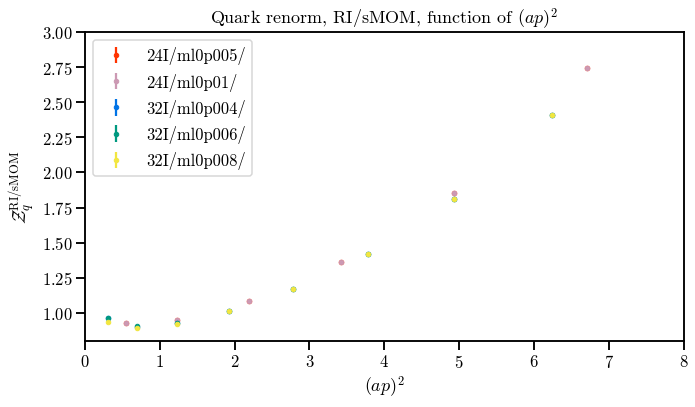

In [12]:
# Zq((ap)^2)
with sns.plotting_context('talk'):
    Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
    Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
    # plt.figure(figsize = (10, 5))
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    plt.ylim((0.8, 3))
    plt.xlim((0, 8))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Quark renorm, RI/sMOM, function of $(ap)^2$')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Zq.pdf')

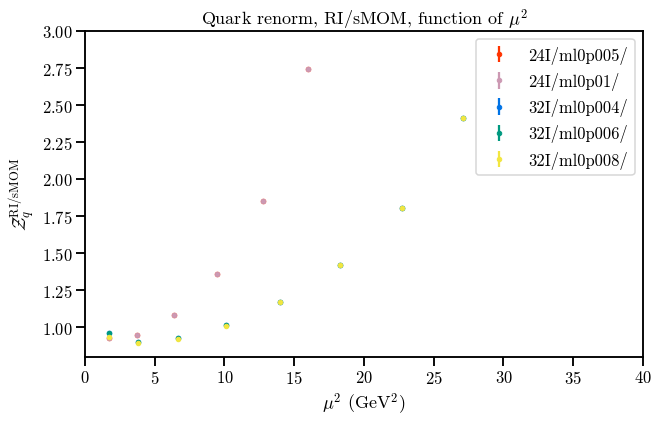

In [204]:
# Zq (μ^2)
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([mu ** 2 for mu in mu_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    plt.ylim((0.8, 3))
    plt.xlim((0, 40))
    plt.xlabel('$\mu^2$ (GeV$^2$)', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Quark renorm, RI/sMOM, function of $\mu^2$')
    plt.legend()
    plt.show()

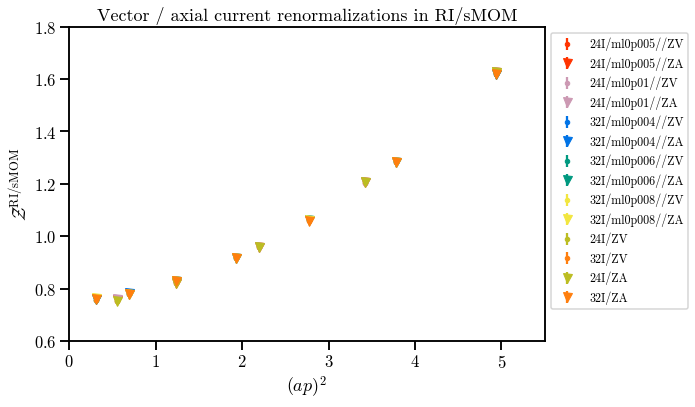

In [205]:
# ZV and ZA
ZV_mu_list = [np.mean(ZV, axis = 1) for ZV in ZV_list]
ZV_sigma_list = [np.std(ZV, axis = 1, ddof = 1) for ZV in ZV_list]
ZA_mu_list = [np.mean(ZA, axis = 1) for ZA in ZA_list]
ZA_sigma_list = [np.std(ZA, axis = 1, ddof = 1) for ZA in ZA_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], ZV_mu_list[idx], ZV_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + '/ZV')
        plt.errorbar([square(k) for k in mom_list[idx]], ZA_mu_list[idx], ZA_sigma_list[idx], fmt = 'v', c = colors[idx], label = ensembles[idx] + '/ZA')

    plt.errorbar([square(k) - stagger for k in mom_list_24I], ZV_extrap_mu[0], ZV_extrap_sigma[0], fmt = '.', c = 'tab:olive', label = '24I/ZV')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], ZV_extrap_mu[1], ZV_extrap_sigma[1], fmt = '.', c = 'tab:orange', label = '32I/ZV')

    plt.errorbar([square(k) - stagger for k in mom_list_24I], ZA_extrap_mu[0], ZA_extrap_sigma[0], fmt = 'v', c = 'tab:olive', label = '24I/ZA')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], ZA_extrap_mu[1], ZA_extrap_sigma[1], fmt = 'v', c = 'tab:orange', label = '32I/ZA')
    plt.ylim((0.6, 1.8))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Vector / axial current renormalizations in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/ZVA.pdf')

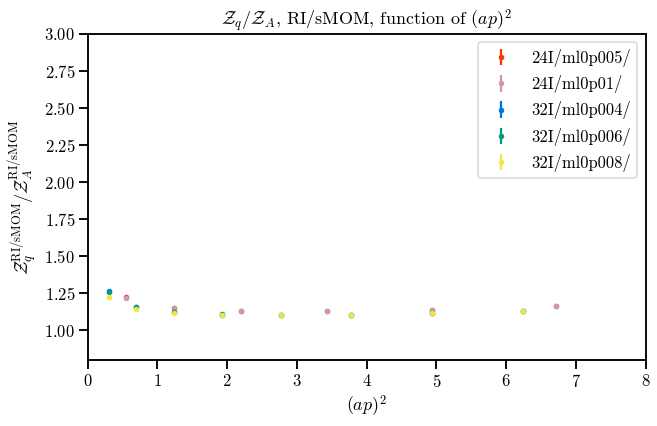

In [15]:
# Zq / ZA
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx] / ZA_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    plt.ylim((0.8, 3))
    plt.xlim((0, 8))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM} / \mathcal{Z}_A^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$\mathcal{Z}_q / \mathcal{Z}_A$, RI/sMOM, function of $(ap)^2$')
    plt.legend()
    plt.show()

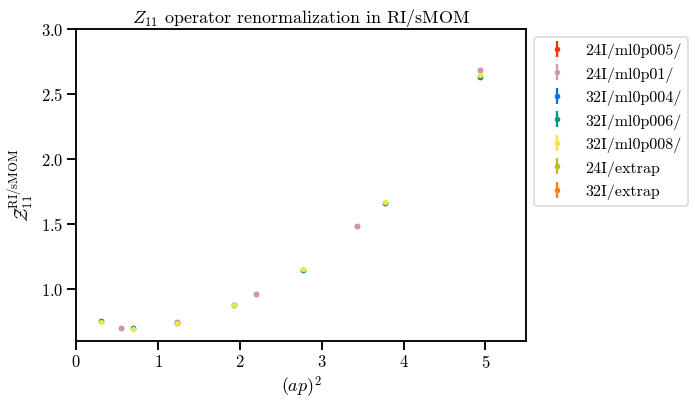

In [16]:
# Z11
Z11_mu_list = [np.mean(Z[0, 0], axis = 1) for Z in Z_list]
Z11_sigma_list = [np.std(Z[0, 0], axis = 1, ddof = 1) for Z in Z_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Z11_mu_list[idx], Z11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    #plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 0, 0], Z_extrap_sigma[0, 0, 0], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
    #plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 0, 0], Z_extrap_sigma[1, 0, 0], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

    # plot linear extrap too
    plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 0, 0], Z_extrap_lin_sigma[0, 0, 0], fmt = '.', c = 'tab:olive', label = '24I/extrap')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 0, 0], Z_extrap_lin_sigma[1, 0, 0], fmt = '.', c = 'tab:orange', label = '32I/extrap')

    plt.ylim((0.6, 3))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_{11}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$Z_{11}$ operator renormalization in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 16})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z11.pdf')

In [ ]:
# are the points Gaussian distributed?
q_idx = 3
hist_data = np.reshape(Z_extrap[0, 0, 0, q_idx], (100,))
plt.figure()
plt.hist(hist_data)
plt.title('Histogram for 24I Z11 values at momentum ' + str(q_idx))
plt.show()

In [ ]:
# Z22
Z22_mu_list = [np.mean(Z[1, 1], axis = 1) for Z in Z_list]
Z22_sigma_list = [np.std(Z[1, 1], axis = 1, ddof = 1) for Z in Z_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx], Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
    #plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1], Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
    #plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1], Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

    # plot linear extrap too
    plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1], Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 1], Z_extrap_lin_sigma[1, 1, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

    plt.ylim((0.2, 4))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$Z_{22}$ operator renormalizations in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z22.pdf')

In [ ]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx] / (ZV_mu_list[idx] ** 2), Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1] / (ZV_mu_list[2] ** 2), Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 1] / (ZV_mu_list[2] ** 2), Z_extrap_lin_sigma[1, 1, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((1, 1.6))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{22} / Z_V^2$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [ ]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
# plot linear extrap too
# plt.errorbar([square(k) for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar(mu_list[0], Z_extrap_lin_mu[0, 1, 1], Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'r')

plt.ylim((0.5, 3.5))
plt.xlim((1, 4))
plt.xlabel('μ (GeV)', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Linear extrap on 24I, $Z_{22}$ operator renormalizations in RI/sMOM')
plt.tight_layout()
plt.show()

In [ ]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
plt.errorbar(mu_list[0], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'r')

# plt.ylim((1.15, 1.3))
# plt.xlim((1, 4.1))
plt.ylim((1.18, 1.22))
plt.xlim((2.4, 3.2))
plt.xlabel('μ (GeV)', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM} / Z_V^2$', fontsize = 18)
plt.title('Linear extrap on 24I, $Z_{22} / Z_V^2$ operator renormalizations in RI/sMOM')
plt.tight_layout()
plt.show()

In [ ]:
# Z33 
Z33_mu_list = [np.mean(Z[2, 2], axis = 1) for Z in Z_list]
Z33_sigma_list = [np.std(Z[2, 2], axis = 1, ddof = 1) for Z in Z_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Z33_mu_list[idx], Z33_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z33')
    #plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 2], Z_extrap_sigma[0, 2, 2], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
    #plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 2], Z_extrap_sigma[1, 2, 2], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

    # plot linear extrap too
    plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 2, 2], Z_extrap_lin_sigma[0, 2, 2], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 2, 2], Z_extrap_lin_sigma[1, 2, 2], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

    plt.ylim((0.2, 3))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$Z_{33}$ operator renormalizations in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z33.pdf')

In [ ]:
# Z23
Z23_mu_list = [np.mean(Z[1, 2], axis = 1) for Z in Z_list]
Z23_sigma_list = [np.std(Z[1, 2], axis = 1, ddof = 1) for Z in Z_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Z23_mu_list[idx], Z23_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    #plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 2], Z_extrap_sigma[0, 1, 2], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
    #plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 2], Z_extrap_sigma[1, 1, 2], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

    # plot linear extrap too
    plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 2], Z_extrap_lin_sigma[0, 1, 2], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 2], Z_extrap_lin_sigma[1, 1, 2], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

    plt.ylim((0.2, 1))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$Z_{23}$ operator renormalizations in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z23.pdf')

In [ ]:
# Z32
Z32_mu_list = [np.mean(Z[2, 1], axis = 1) for Z in Z_list]
Z32_sigma_list = [np.std(Z[2, 1], axis = 1, ddof = 1) for Z in Z_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Z32_mu_list[idx], Z32_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    #plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 1], Z_extrap_sigma[0, 2, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
    #plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 1], Z_extrap_sigma[1, 2, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

    # plot linear extrap too
    plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 2, 1], Z_extrap_lin_sigma[0, 2, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 2, 1], Z_extrap_lin_sigma[1, 2, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

    plt.ylim((0, 0.2))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$Z_{32}$ operator renormalizations in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z32.pdf')

In [ ]:
# Z44
Z44_mu_list = [np.mean(Z[3, 3], axis = 1) for Z in Z_list]
Z44_sigma_list = [np.std(Z[3, 3], axis = 1, ddof = 1) for Z in Z_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    for idx in range(n_ens):
        plt.errorbar([square(k) for k in mom_list[idx]], Z44_mu_list[idx], Z44_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    #plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 3], Z_extrap_sigma[0, 3, 3], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
    #plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 3], Z_extrap_sigma[1, 3, 3], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

    # plot linear extrap too
    plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 3, 3], Z_extrap_lin_sigma[0, 3, 3], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
    plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 3, 3], Z_extrap_lin_sigma[1, 3, 3], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

    plt.ylim((0.3, 3.5))
    plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('$Z_{44}$ operator renormalization in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z44.pdf')

In [ ]:
# Z55
Z55_mu_list = [np.mean(Z[4, 4], axis = 1) for Z in Z_list]
Z55_sigma_list = [np.std(Z[4, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z55_mu_list[idx], Z55_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 4], Z_extrap_sigma[0, 4, 4], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 4], Z_extrap_sigma[1, 4, 4], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 4, 4], Z_extrap_lin_sigma[0, 4, 4], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 4, 4], Z_extrap_lin_sigma[1, 4, 4], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.3, 4.0))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{55}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z55.pdf')

In [ ]:
# Z45
Z45_mu_list = [np.mean(Z[3, 4], axis = 1) for Z in Z_list]
Z45_sigma_list = [np.std(Z[3, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z45_mu_list[idx], Z45_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 4], Z_extrap_sigma[0, 3, 4], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 4], Z_extrap_sigma[1, 3, 4], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 3, 4], Z_extrap_lin_sigma[0, 3, 4], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 3, 4], Z_extrap_lin_sigma[1, 3, 4], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((-0.2, 0.05))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{45}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z45.pdf')

In [ ]:
# Z54
Z54_mu_list = [np.mean(Z[4, 3], axis = 1) for Z in Z_list]
Z54_sigma_list = [np.std(Z[4, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z54_mu_list[idx], Z54_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 3], Z_extrap_sigma[0, 4, 3], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 3], Z_extrap_sigma[1, 4, 3], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 4, 3], Z_extrap_lin_sigma[0, 4, 3], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 4, 3], Z_extrap_lin_sigma[1, 4, 3], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((-1, -0.1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{54}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Z54.pdf')

## Fit $Z_V, Z_A, Z_q$

In [189]:
def fit_and_plot_ZqAV(data, mus, pwr, label, x_range = [0., 6.5], y_range = [0.5, 2.5], quad = False, x_label = '$\\mu$ (GeV)'):
    ne = data.shape[1]
    fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(mus, data, order = pwr, label = label, mu1 = 0., quad = quad)
    # need to extract value at (ap)^2 = 0
    # x_fit_b = np.linspace(2, 5)
    x_fit_b = np.linspace(x_range[0], x_range[1])
    fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
    for ii in range(pwr + 1):
        ci_mu_b = np.mean(fit_coeffs_b[ii])
        if quad:
            moment = x_fit_b ** (2 * ii)
        else:
            moment = x_fit_b ** (ii)
        fx_fit_b += ci_mu_b * moment
    Z_fit_mean = np.zeros((len(mus)), dtype = np.float64)
    Z_fit_std = np.zeros((len(mus)), dtype = np.float64)
    for i in range(len(mus)):
        fit_data_boots = Superboot(ne)
        fit_data_boots.boots = data[i]
        Z_fit_mean[i] = fit_data_boots.compute_mean()
        Z_fit_std[i] = fit_data_boots.compute_std()
    extrap_ens = Superboot(ne)
    extrap_ens.boots = y_extrap_b
    extrap_mu = extrap_ens.compute_mean()
    extrap_std = extrap_ens.compute_std()
    print('Interpolated value: ' + export_float_latex(extrap_mu, extrap_std, sf = 1))
    ndof = len(mus) - (pwr + 1)
    print('ndof = ' + str(ndof))
    print('chi^2 / ndof = ' + str(np.mean(chi2_b) / ndof))
    
    with sns.plotting_context('talk'):
        plt.figure(figsize = (10, 6))
        plt.errorbar(mus, Z_fit_mean, Z_fit_std, fmt = '.')
        plt.plot(x_fit_b, fx_fit_b, c = 'r')
        plt.title('Fit for ' + label, fontsize = 20)
        plt.xlim(x_range)
        plt.ylim(y_range)
        plt.xlabel(x_label, fontsize = 16)
        plt.ylabel(label, fontsize = 16)
        plt.tight_layout()
        plt.show()

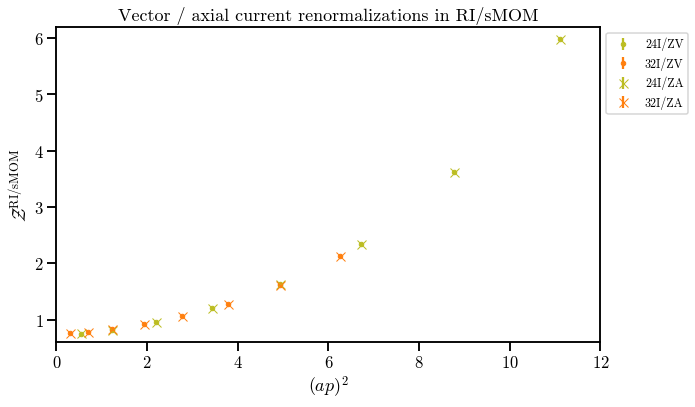

In [51]:
# ZV and ZA
ZV_mu_list = [np.mean(ZV, axis = 1) for ZV in ZV_list]
ZV_sigma_list = [np.std(ZV, axis = 1, ddof = 1) for ZV in ZV_list]
ZA_mu_list = [np.mean(ZA, axis = 1) for ZA in ZA_list]
ZA_sigma_list = [np.std(ZA, axis = 1, ddof = 1) for ZA in ZA_list]
with sns.plotting_context('talk'):
    plt.figure(figsize = (10, 6))
    
    plt.errorbar([square(k) for k in mom_list_24I], ZV_extrap_mu[0], ZV_extrap_sigma[0], fmt = '.', c = 'tab:olive', label = '24I/ZV')
    plt.errorbar([square(k) for k in mom_list_32I], ZV_extrap_mu[1], ZV_extrap_sigma[1], fmt = '.', c = 'tab:orange', label = '32I/ZV')
    plt.errorbar([square(k) for k in mom_list_24I], ZA_extrap_mu[0], ZA_extrap_sigma[0], fmt = 'x', c = 'tab:olive', label = '24I/ZA')
    plt.errorbar([square(k) for k in mom_list_32I], ZA_extrap_mu[1], ZA_extrap_sigma[1], fmt = 'x', c = 'tab:orange', label = '32I/ZA')
    
    # plt.ylim((0.6, 2.5))
    # plt.xlim((0, 6.5))
    plt.ylim((0.6, 6.2))
    plt.xlim((0, 12))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Vector / axial current renormalizations in RI/sMOM')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
    plt.tight_layout()
    plt.show()

In [213]:
[square(mom_list_24I[idx]) for idx in range(len(mom_list_24I))]

[0.5483113556160754,
 1.2337005501361697,
 2.1932454224643014,
 3.426945972600472,
 4.934802200544679,
 6.7168141062969235,
 8.772981689857206,
 11.103304951225528]

Fitting c0
+ c1 \mu^1
+ c2 \mu^2
[0.71367384 0.05505809 0.02584027]
Chi^2: 0.44577121362332817
Extrapolated $\mathcal{Z}_V/24I$ = 0.713673836426293
[0.71356248 0.05534881 0.02573772]
Chi^2: 0.016559237064195542
Extrapolated $\mathcal{Z}_V/24I$ = 0.7135624794665212
[0.71110499 0.0574176  0.02536067]
Chi^2: 0.44895536982348766
Extrapolated $\mathcal{Z}_V/24I$ = 0.7111049877966884
[0.71102765 0.05760591 0.02529483]
Chi^2: 0.2901935686047851
Extrapolated $\mathcal{Z}_V/24I$ = 0.711027648663449
[0.7086233  0.05935917 0.02497099]
Chi^2: 0.03400082170178421
Extrapolated $\mathcal{Z}_V/24I$ = 0.7086232976840469
[0.712904   0.05625164 0.02550852]
Chi^2: 0.001981058115546619
Extrapolated $\mathcal{Z}_V/24I$ = 0.7129039961459113
[0.71347821 0.056272   0.02549958]
Chi^2: 0.2005400584554086
Extrapolated $\mathcal{Z}_V/24I$ = 0.7134782050347745
[0.71195691 0.05658606 0.0255213 ]
Chi^2: 0.15637288726383097
Extrapolated $\mathcal{Z}_V/24I$ = 0.7119569102090499
[0.7124226  0.05659757 0.02543473]
Chi^2:

[0.71305814 0.05598348 0.025585  ]
Chi^2: 0.18800847442828728
Extrapolated $\mathcal{Z}_V/24I$ = 0.7130581385403507
Interpolated value: 0.712(2)
ndof = 1
chi^2 / ndof = 0.3667734866352363


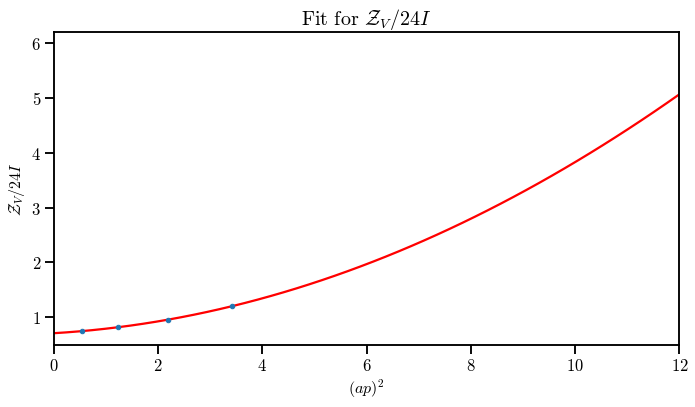

In [190]:
# ZV/24I
mom_subset = [0, 1, 2, 3]
pwr = 2
fit_and_plot_ZqAV(ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, \
                  '$\mathcal{Z}_V/24I$', x_range = [0, 12], y_range = [0.5, 6.2], x_label = '$(ap)^2$', quad = False)

Fitting c0
+ c1 \mu^1
+ c2 \mu^2
[0.71487733 0.05428671 0.02596677]
Chi^2: 1.1889063326833422
Extrapolated $\mathcal{Z}_A/24I$ = 0.7148773313638142
[0.71507058 0.05425843 0.02593048]
Chi^2: 0.19275077963602058
Extrapolated $\mathcal{Z}_A/24I$ = 0.7150705774506679
[0.71295431 0.05612047 0.02558439]
Chi^2: 1.1666713889394513
Extrapolated $\mathcal{Z}_A/24I$ = 0.7129543060061985
[0.71274126 0.05628156 0.02553822]
Chi^2: 0.002110220854851391
Extrapolated $\mathcal{Z}_A/24I$ = 0.712741259980062
[0.7101823  0.05819307 0.02517997]
Chi^2: 0.21427568674161268
Extrapolated $\mathcal{Z}_A/24I$ = 0.7101823039151304
[0.71430597 0.05520717 0.0256973 ]
Chi^2: 0.1912778672356043
Extrapolated $\mathcal{Z}_A/24I$ = 0.7143059679866935
[0.71522202 0.05488509 0.02575925]
Chi^2: 0.9109304848675587
Extrapolated $\mathcal{Z}_A/24I$ = 0.715222023798525
[0.71333142 0.05561439 0.02568998]
Chi^2: 0.881445774836121
Extrapolated $\mathcal{Z}_A/24I$ = 0.7133314206031229
[0.71441258 0.05504889 0.02572073]
Chi^2: 0.47

[0.71343323 0.05579024 0.02561083]
Chi^2: 0.9985985280301345
Extrapolated $\mathcal{Z}_A/24I$ = 0.713433228346071
[0.71430887 0.0548428  0.02578996]
Chi^2: 1.1802894350207493
Extrapolated $\mathcal{Z}_A/24I$ = 0.7143088743290821
[0.71488418 0.05486802 0.02574756]
Chi^2: 1.3902187818412977
Extrapolated $\mathcal{Z}_A/24I$ = 0.7148841815021956
[0.71284268 0.055965   0.02561147]
Chi^2: 0.8191843972880707
Extrapolated $\mathcal{Z}_A/24I$ = 0.7128426798441391
[0.71468383 0.05474632 0.02581106]
Chi^2: 0.8546554354028659
Extrapolated $\mathcal{Z}_A/24I$ = 0.7146838273796979
Interpolated value: 0.714(2)
ndof = 1
chi^2 / ndof = 0.9606195618563386


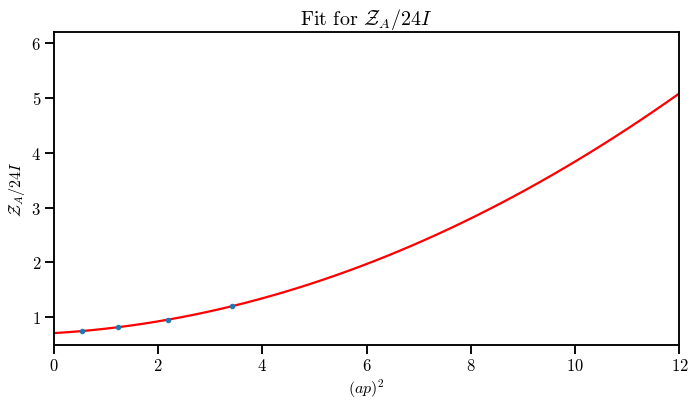

In [191]:
# ZA/24I
mom_subset = [0, 1, 2, 3]
pwr = 2
fit_and_plot_ZqAV(ZA_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, \
                  '$\mathcal{Z}_A/24I$', x_range = [0, 12], y_range = [0.5, 6.2], x_label = '$(ap)^2$')

Fitting c0
+ c1 \mu^1
+ c2 \mu^2
[0.7434554  0.03443505 0.02882918]
Chi^2: 0.5143015378075355
Extrapolated $\mathcal{Z}_V/32I$ = 0.7434553974481466
[0.74519596 0.03140073 0.02986703]
Chi^2: 2.404166039574719
Extrapolated $\mathcal{Z}_V/32I$ = 0.7451959612860494
[0.73770513 0.04117095 0.02679284]
Chi^2: 0.31028904833136317
Extrapolated $\mathcal{Z}_V/32I$ = 0.7377051282819792
[0.74331323 0.03311939 0.0294016 ]
Chi^2: 0.5030230096648931
Extrapolated $\mathcal{Z}_V/32I$ = 0.7433132317191262
[0.74342564 0.03417184 0.0289024 ]
Chi^2: 1.2544936559115398
Extrapolated $\mathcal{Z}_V/32I$ = 0.7434256352904931
[0.74457184 0.03292929 0.02929995]
Chi^2: 0.0005960115081897571
Extrapolated $\mathcal{Z}_V/32I$ = 0.7445718424288984
[0.74710844 0.02911514 0.03057619]
Chi^2: 0.39428199931086566
Extrapolated $\mathcal{Z}_V/32I$ = 0.7471084364280823
[0.74543783 0.0303749  0.03029643]
Chi^2: 0.8405840000375512
Extrapolated $\mathcal{Z}_V/32I$ = 0.745437831258801
[0.74335422 0.03443581 0.0287519 ]
Chi^2: 0.

[0.74420898 0.03329716 0.02915178]
Chi^2: 0.9618451345917624
Extrapolated $\mathcal{Z}_V/32I$ = 0.744208983334542
[0.74273886 0.03481002 0.02874195]
Chi^2: 1.115394313351736
Extrapolated $\mathcal{Z}_V/32I$ = 0.7427388620570015
[0.7423399  0.03544807 0.02853353]
Chi^2: 2.292250577274425
Extrapolated $\mathcal{Z}_V/32I$ = 0.7423398988477401
[0.74358834 0.03417114 0.02886228]
Chi^2: 0.9095360764907277
Extrapolated $\mathcal{Z}_V/32I$ = 0.7435883366479725
[0.74575906 0.02981205 0.03054051]
Chi^2: 0.43604867212495657
Extrapolated $\mathcal{Z}_V/32I$ = 0.7457590570252888
[0.74532471 0.0310238  0.03001274]
Chi^2: 0.14178672943988122
Extrapolated $\mathcal{Z}_V/32I$ = 0.7453247105891375
[0.746654   0.02977397 0.0303245 ]
Chi^2: 0.00304452451261571
Extrapolated $\mathcal{Z}_V/32I$ = 0.7466540012564634
[0.74347698 0.03451462 0.02871718]
Chi^2: 1.332688290715929
Extrapolated $\mathcal{Z}_V/32I$ = 0.743476979624131
[0.74441737 0.03203257 0.02975248]
Chi^2: 1.1533274940379221
Extrapolated $\mathca

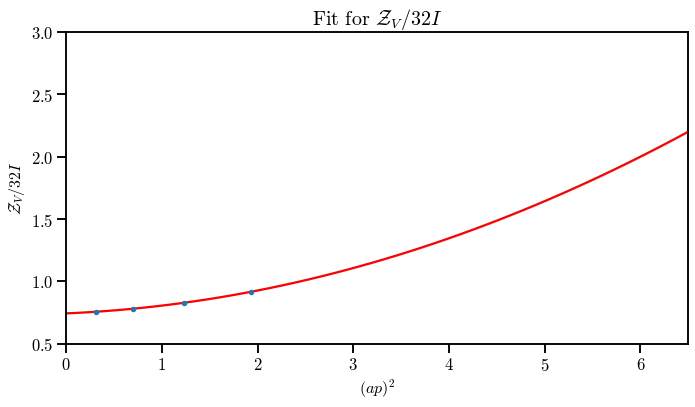

In [192]:
# ZV/32I
mom_subset = [0, 1, 2, 3]
pwr = 2
fit_and_plot_ZqAV(ZV_extrap[1][mom_subset], np.array([square(mom_list_32I[idx]) for idx in mom_subset]), pwr, \
                  '$\mathcal{Z}_V/32I$', x_range = [0, 6.5], y_range = [0.5, 3.], x_label = '$(ap)^2$')

Fitting c0
+ c1 \mu^1
+ c2 \mu^2
[0.7441809  0.03343923 0.0291454 ]
Chi^2: 0.7461709334992341
Extrapolated $\mathcal{Z}_A/32I$ = 0.7441809038969536
[0.74547114 0.03102785 0.02997932]
Chi^2: 2.317772590770712
Extrapolated $\mathcal{Z}_A/32I$ = 0.7454711382896191
[0.73797128 0.04075293 0.02693418]
Chi^2: 0.314282841426013
Extrapolated $\mathcal{Z}_A/32I$ = 0.7379712787292929
[0.74347345 0.03305834 0.0293824 ]
Chi^2: 0.5802874036608573
Extrapolated $\mathcal{Z}_A/32I$ = 0.7434734481036475
[0.74389263 0.0335582  0.0290924 ]
Chi^2: 1.2314058029564645
Extrapolated $\mathcal{Z}_A/32I$ = 0.7438926261244273
[0.74480995 0.0325471  0.02943438]
Chi^2: 0.04571585567313454
Extrapolated $\mathcal{Z}_A/32I$ = 0.7448099463972363
[0.74738694 0.02876691 0.03067813]
Chi^2: 0.5325017740343857
Extrapolated $\mathcal{Z}_A/32I$ = 0.7473869380934265
[0.74577771 0.02993722 0.03042788]
Chi^2: 0.9050940306098808
Extrapolated $\mathcal{Z}_A/32I$ = 0.7457777079744862
[0.74386682 0.03381186 0.02893647]
Chi^2: 0.2123

[0.74465602 0.03238902 0.02949275]
Chi^2: 0.6313065853110356
Extrapolated $\mathcal{Z}_A/32I$ = 0.7446560234785776
[0.74360256 0.03435627 0.02874996]
Chi^2: 1.2884159358392901
Extrapolated $\mathcal{Z}_A/32I$ = 0.7436025579737277
[0.74413044 0.03207309 0.02979765]
Chi^2: 0.8538100281368645
Extrapolated $\mathcal{Z}_A/32I$ = 0.7441304385602571
[0.74287776 0.03437659 0.0289332 ]
Chi^2: 1.8144676507313726
Extrapolated $\mathcal{Z}_A/32I$ = 0.7428777640409023
[0.74527047 0.03128374 0.02989735]
Chi^2: 0.5385599157184813
Extrapolated $\mathcal{Z}_A/32I$ = 0.7452704667857476
[0.74650335 0.0289253  0.03078794]
Chi^2: 0.09106853913340089
Extrapolated $\mathcal{Z}_A/32I$ = 0.7465033527996128
[0.74471301 0.03216759 0.02959303]
Chi^2: 0.734360460360258
Extrapolated $\mathcal{Z}_A/32I$ = 0.744713008859553
[0.7457769  0.03002295 0.03040872]
Chi^2: 0.3599660051825547
Extrapolated $\mathcal{Z}_A/32I$ = 0.7457768964950445
[0.74575274 0.03131139 0.02974896]
Chi^2: 0.0021896658577673952
Extrapolated $\ma

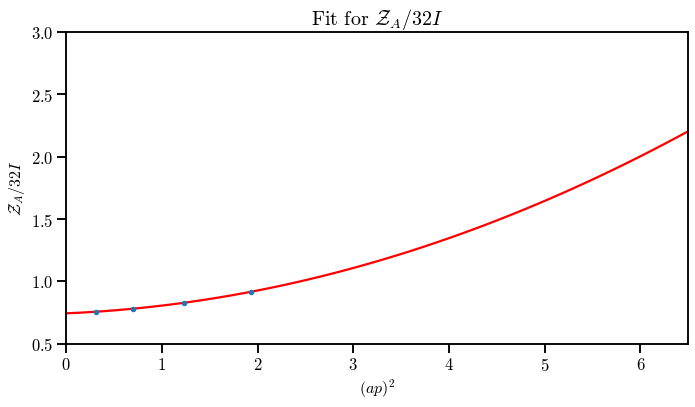

In [193]:
# ZA/32I
mom_subset = [0, 1, 2, 3]
pwr = 2
fit_and_plot_ZqAV(ZA_extrap[1][mom_subset], np.array([square(mom_list_32I[idx]) for idx in mom_subset]), pwr, \
                  '$\mathcal{Z}_A/32I$', x_range = [0, 6.5], y_range = [0.5, 3.], x_label = '$(ap)^2$')

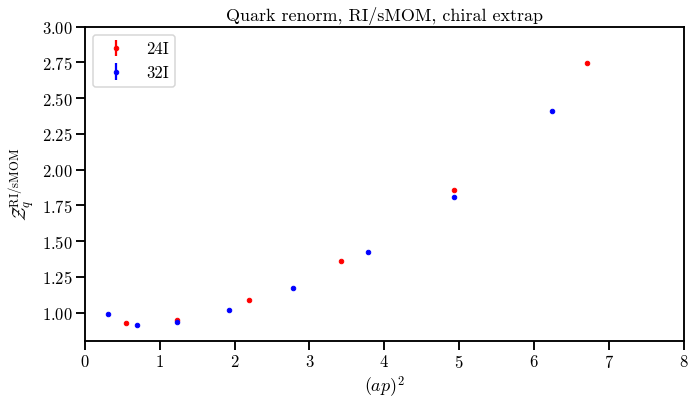

In [37]:
# Zq((ap)^2)
with sns.plotting_context('talk'):
    Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
    Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
    plt.figure(figsize = (10, 6))
    
    plt.errorbar([square(k) for k in mom_list_24I], Zq_extrap_mu[0], Zq_extrap_sigma[0], fmt = '.', c = 'r', label = '24I')
    plt.errorbar([square(k) for k in mom_list_32I], Zq_extrap_mu[1], Zq_extrap_sigma[1], fmt = '.', c = 'b', label = '32I')
    
    plt.ylim((0.8, 3))
    plt.xlim((0, 8))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Quark renorm, RI/sMOM, chiral extrap')
    plt.legend()
    plt.tight_layout()
    plt.show()

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 9.10691793e-01  3.84407832e-02 -1.69090676e-05  1.49271417e-06]
Chi^2: 0.041195553186306084
Extrapolated $\mathcal{Z}_q/24I$ = 0.9106917931136082
[ 9.09151732e-01  3.84364154e-02 -1.71366022e-05  1.49290025e-06]
Chi^2: 0.032555417655271396
Extrapolated $\mathcal{Z}_q/24I$ = 0.909151732206447
[ 9.07590346e-01  3.84465763e-02 -1.73862119e-05  1.49371544e-06]
Chi^2: 0.021307852000831237
Extrapolated $\mathcal{Z}_q/24I$ = 0.907590345551665
[ 9.09000412e-01  3.84273073e-02 -1.71361936e-05  1.49297462e-06]
Chi^2: 0.031429343001926104
Extrapolated $\mathcal{Z}_q/24I$ = 0.90900041207036
[ 9.08557735e-01  3.84083258e-02 -1.70169891e-05  1.49182063e-06]
Chi^2: 0.04383965877605977
Extrapolated $\mathcal{Z}_q/24I$ = 0.9085577351856126
[ 9.10292672e-01  3.84018229e-02 -1.66378886e-05  1.49087104e-06]
Chi^2: 0.04239056127782468
Extrapolated $\mathcal{Z}_q/24I$ = 0.9102926716920101
[ 9.09404236e-01  3.84449798e-02 -1.73647432e-05  1.49420352e-06]
Chi^2: 0

[ 9.09169653e-01  3.84275868e-02 -1.71108662e-05  1.49281454e-06]
Chi^2: 0.02995360962832039
Extrapolated $\mathcal{Z}_q/24I$ = 0.9091696525968375
[ 9.09548915e-01  3.84279837e-02 -1.69475022e-05  1.49235850e-06]
Chi^2: 0.02697873741835665
Extrapolated $\mathcal{Z}_q/24I$ = 0.9095489153005258
[ 9.09574060e-01  3.84309585e-02 -1.70150276e-05  1.49266675e-06]
Chi^2: 0.03646565882188915
Extrapolated $\mathcal{Z}_q/24I$ = 0.9095740601001284
[ 9.09543995e-01  3.84348175e-02 -1.70689510e-05  1.49292506e-06]
Chi^2: 0.027196218209683872
Extrapolated $\mathcal{Z}_q/24I$ = 0.909543994593619
[ 9.08730176e-01  3.84321394e-02 -1.71819922e-05  1.49298938e-06]
Chi^2: 0.024792654968116105
Extrapolated $\mathcal{Z}_q/24I$ = 0.9087301759565479
[ 9.09214774e-01  3.84218165e-02 -1.70018086e-05  1.49216736e-06]
Chi^2: 0.051178076801974934
Extrapolated $\mathcal{Z}_q/24I$ = 0.9092147738511176
[ 9.09259743e-01  3.84301397e-02 -1.70885591e-05  1.49274354e-06]
Chi^2: 0.033097702193571506
Extrapolated $\mathcal

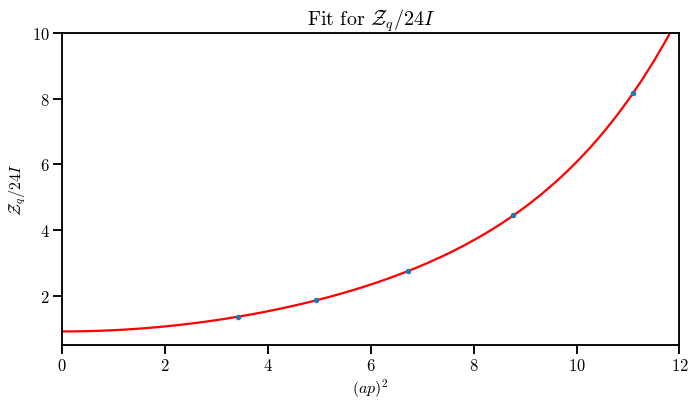

In [194]:
# Zq/24I
mom_subset = [3, 4, 5, 6, 7]
# mom_subset = [4, 5, 6, 7]
pwr = 3
# TODO allow this to have the powers specified exactly
fit_and_plot_ZqAV(Zq_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, \
                  '$\mathcal{Z}_q/24I$', x_range = [0, 12], y_range = [0.5, 10.], x_label = '$(ap)^2$', quad = True)

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 8.75734088e-01  3.92826697e-02 -1.04312551e-04  2.74120980e-06]
Chi^2: 3.7640682847079288
Extrapolated $\mathcal{Z}_q/32I$ = 0.8757340879737622
[ 8.75554510e-01  3.92597816e-02 -1.03255320e-04  2.72634625e-06]
Chi^2: 5.244458110544487
Extrapolated $\mathcal{Z}_q/32I$ = 0.8755545104461031
[ 8.76288715e-01  3.93114149e-02 -1.04717550e-04  2.74522292e-06]
Chi^2: 3.665762686015998
Extrapolated $\mathcal{Z}_q/32I$ = 0.8762887147906654
[ 8.76217335e-01  3.93078546e-02 -1.05312830e-04  2.75943801e-06]
Chi^2: 3.988961180098867
Extrapolated $\mathcal{Z}_q/32I$ = 0.8762173350135561
[ 8.74694097e-01  3.93228122e-02 -1.06284200e-04  2.76830453e-06]
Chi^2: 4.290970654249035
Extrapolated $\mathcal{Z}_q/32I$ = 0.874694096699467
[ 8.75431251e-01  3.92459718e-02 -1.02824048e-04  2.71867974e-06]
Chi^2: 4.119526375831114
Extrapolated $\mathcal{Z}_q/32I$ = 0.8754312507937426
[ 8.74884432e-01  3.93210992e-02 -1.05664937e-04  2.75623046e-06]
Chi^2: 3.23983405620

[ 8.75525170e-01  3.93019599e-02 -1.05048731e-04  2.75132140e-06]
Chi^2: 4.364523597069788
Extrapolated $\mathcal{Z}_q/32I$ = 0.8755251695075063
[ 8.75088434e-01  3.93128642e-02 -1.05360931e-04  2.75399755e-06]
Chi^2: 3.8187465306669246
Extrapolated $\mathcal{Z}_q/32I$ = 0.875088434023305
[ 8.75150925e-01  3.93043960e-02 -1.05079369e-04  2.75040292e-06]
Chi^2: 3.8190382628922985
Extrapolated $\mathcal{Z}_q/32I$ = 0.87515092475585
[ 8.75465500e-01  3.92756339e-02 -1.03691806e-04  2.73075813e-06]
Chi^2: 4.232993582019716
Extrapolated $\mathcal{Z}_q/32I$ = 0.8754654996056855
[ 8.75135862e-01  3.93152932e-02 -1.05609296e-04  2.75833718e-06]
Chi^2: 3.656881875150318
Extrapolated $\mathcal{Z}_q/32I$ = 0.8751358617425786
[ 8.75459963e-01  3.92765177e-02 -1.03675876e-04  2.73021227e-06]
Chi^2: 4.206056786517073
Extrapolated $\mathcal{Z}_q/32I$ = 0.8754599626522921
[ 8.75561874e-01  3.92752402e-02 -1.03811536e-04  2.73322198e-06]
Chi^2: 4.17842491566991
Extrapolated $\mathcal{Z}_q/32I$ = 0.8755

[ 8.75514381e-01  3.92609575e-02 -1.03020620e-04  2.71997495e-06]
Chi^2: 4.570074540359382
Extrapolated $\mathcal{Z}_q/32I$ = 0.8755143807704683
[ 8.75266382e-01  3.92770186e-02 -1.03991608e-04  2.73493228e-06]
Chi^2: 3.8763645773075757
Extrapolated $\mathcal{Z}_q/32I$ = 0.8752663815878522
[ 8.75565546e-01  3.92873774e-02 -1.03920692e-04  2.73406833e-06]
Chi^2: 3.9661530834136487
Extrapolated $\mathcal{Z}_q/32I$ = 0.8755655455387623
[ 8.75391039e-01  3.92873926e-02 -1.04329222e-04  2.73947036e-06]
Chi^2: 4.391364078879334
Extrapolated $\mathcal{Z}_q/32I$ = 0.8753910386001421
[ 8.75283254e-01  3.92834490e-02 -1.04312081e-04  2.73968386e-06]
Chi^2: 4.205656051264345
Extrapolated $\mathcal{Z}_q/32I$ = 0.8752832541386603
[ 8.75207658e-01  3.92821515e-02 -1.04239144e-04  2.73785727e-06]
Chi^2: 3.939999029439417
Extrapolated $\mathcal{Z}_q/32I$ = 0.8752076578977508
[ 8.75643415e-01  3.92744712e-02 -1.03647267e-04  2.73112404e-06]
Chi^2: 4.18328046687618
Extrapolated $\mathcal{Z}_q/32I$ = 0.8

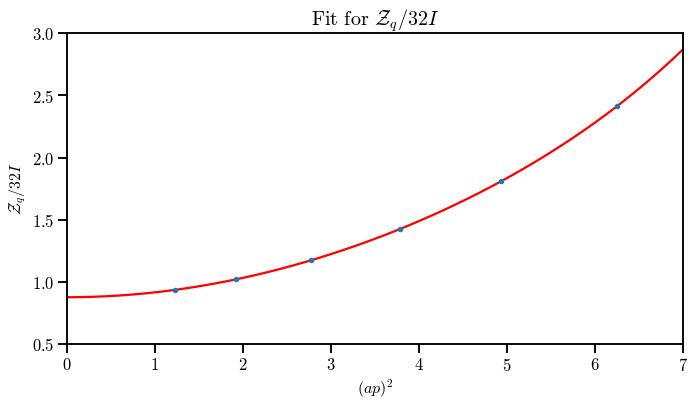

In [201]:
# Zq/32I
mom_subset = [2, 3, 4, 5, 6, 7]
pwr = 3
fit_and_plot_ZqAV(Zq_extrap[1][mom_subset], np.array([square(mom_list_32I[idx]) for idx in mom_subset]), pwr, \
                  '$\mathcal{Z}_q/32I$', x_range = [0, 7.], y_range = [0.5, 3.], x_label = '$(ap)^2$', quad = True)

## Fit each $Z_{ij} / Z_V^2$ as a function of $(ap)^2$, interpolate to $\mu_1 = 3$ GeV

In [ ]:
spacing_idx = 0    # 0 for 24I, 1 for 32I
# spacing_idx = 1
Z_chiral_boots = np.zeros(Z_extrap_lin[spacing_idx].shape, dtype = np.float64)     # Z_ij / ZV^2
for pidx in range(n_mom):
    for eidx in range(n_spacings):
        for bidx in range(n_boots[0]):
            Z_chiral_boots[:, :, pidx, eidx, bidx] = Z_extrap_lin[spacing_idx, :, :, pidx, eidx, bidx] / \
                (ZV_list[2 * spacing_idx + eidx][pidx, bidx] ** 2)
Z_chiral_mu = np.zeros((5, 5, n_mom), dtype = np.float64)
Z_chiral_sigma = np.zeros((5, 5, n_mom), dtype = np.float64)
for i, j in itertools.product(range(5), repeat = 2):
    for pidx in range(n_mom):
        tmp = Superboot(n_spacings)
        tmp.boots = Z_chiral_boots[i, j, pidx]
        Z_chiral_mu[i, j, pidx] = tmp.compute_mean()
        Z_chiral_sigma[i, j, pidx] = tmp.compute_std()
scales = mu_list[2 * spacing_idx]

In [ ]:
# # choose lattice spacing and plot as a function of scale
# spacing_idx = 0        # 0 for 24I, 1 for 32I
# Z_chiral_boots = Z_extrap_lin[spacing_idx]
# Z_chiral_mu = Z_extrap_lin_mu[spacing_idx]
# Z_chiral_sigma = Z_extrap_lin_sigma[spacing_idx]
# scales = mu_list[2 * spacing_idx]

In [ ]:
plt.figure()
plt.errorbar(scales ** 2, Z_chiral_mu[0, 0], Z_chiral_sigma[0, 0], marker = '.', fmt = '.')
plt.xlabel('μ^2 (GeV^2)')
plt.ylabel('$Z_{11} / Z_V^2$')
plt.xlim((0, 17))
plt.ylim((0, 2))
plt.title('$Z_{11} / Z_V^2$')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2)
for i, j in itertools.product(range(2), repeat = 2):
    ax[i, j].errorbar(scales ** 2, Z_chiral_mu[i + 1, j + 1], Z_chiral_sigma[i + 1, j + 1], marker = '.', fmt = '.')
    ax[i, j].set_xlim((0, 20))
    ax[i, j].set_title('Z' + str(i + 2) + str(j + 2) + '/$Z_V^2$')
    ax[i, j].set_xlabel('μ^2 (GeV^2)')
    ax[i, j].set_ylabel('Z' + str(i + 2) + str(j + 2) + '/$Z_V^2')
ax[0, 0].set_ylim((1, 1.5))
ax[0, 1].set_ylim((0.2, 0.6))
ax[1, 0].set_ylim((0, 0.2))
ax[1, 1].set_ylim((0.5, 1.5))
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2)
for i, j in itertools.product(range(2), repeat = 2):
    ax[i, j].errorbar(scales ** 2, Z_chiral_mu[i + 3, j + 3], Z_chiral_sigma[i + 3, j + 3], marker = '.', fmt = '.')
    ax[i, j].set_xlim((0, 20))
    ax[i, j].set_title('Z' + str(i + 4) + str(j + 4) + '/$Z_V^2$')
    ax[i, j].set_xlabel('μ^2 (GeV^2)')
    ax[i, j].set_ylabel('Z' + str(i + 4) + str(j + 4) + '/$Z_V^2$')
ax[0, 0].set_ylim((0, 2))
ax[0, 1].set_ylim((-0.2, 0.1))
ax[1, 0].set_ylim((-0.5, -0.2))
ax[1, 1].set_ylim((1, 2))
plt.tight_layout()
plt.show()

In [ ]:
def fit_and_plot(data, mus, pwr, label, x_range = [2, 5], x_label = '$\\mu$ (GeV)'):
    fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(mus, data, order = pwr)
    # x_fit_b = np.linspace(2, 5)
    x_fit_b = np.linspace(x_range[0], x_range[1])
    fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
    for ii in range(pwr + 1):
        ci_mu_b = np.mean(fit_coeffs_b[ii])
        moment = x_fit_b ** (2 * ii)
        fx_fit_b += ci_mu_b * moment
    Z_fit_mean = np.zeros((len(mus)), dtype = np.float64)
    Z_fit_std = np.zeros((len(mus)), dtype = np.float64)
    for i in range(len(mus)):
        fit_data_boots = Superboot(2)
        fit_data_boots.boots = data[i]
        Z_fit_mean[i] = fit_data_boots.compute_mean()
        Z_fit_std[i] = fit_data_boots.compute_std()
    print(y_extrap_b.shape)
    extrap_ens = Superboot(2)
    extrap_ens.boots = y_extrap_b
    extrap_mu = extrap_ens.compute_mean()
    extrap_std = extrap_ens.compute_std()
    #print('Interpolated value: ' + str(extrap_mu) + ' \pm ' + str(extrap_std))
    print('Interpolated value: ' + export_float_latex(extrap_mu, extrap_std, sf = 1))
    ndof = len(mus) - (pwr + 1)
    print('ndof = ' + str(ndof))
    print('chi^2 / ndof = ' + str(np.mean(chi2_b) / ndof))
    plt.figure()
    plt.errorbar(mus, Z_fit_mean, Z_fit_std, fmt = '.')
    plt.plot(x_fit_b, fx_fit_b, c = 'r')
    plt.title('Fit for ' + label, fontsize = 20)
    plt.xlabel(x_label, fontsize = 16)
    plt.ylabel(label, fontsize = 16)
    plt.tight_layout()
    plt.show()

In [ ]:
# mom_subset = [2, 3, 4, 5, 6, 7]
# pwr = 3
mom_subset = [3, 4, 5, 6]
pwr = 2
fit_and_plot(Z_chiral_boots[0, 0, mom_subset], scales[mom_subset], pwr, '$\\mathcal{Z}_{11} / \\mathcal{Z}_V^{\\; 2}$')

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/24I/Z11ZVsq_interp.pdf')

In [ ]:
# mom_subset = [2, 3, 4, 5]
# pwr = 2
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[1, 1, mom_subset], scales[mom_subset], pwr, '$Z_{22} / Z_V^2$')

In [ ]:
# mom_subset = [3, 4, 5, 6]
# pwr = 2
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[1, 2, mom_subset], scales[mom_subset], pwr, '$Z_{23} / Z_V^2$')

In [ ]:
# mom_subset = [3, 4, 5, 6]
# pwr = 3
mom_subset = [2, 3, 4, 5, 6]
pwr = 3
fit_and_plot(Z_chiral_boots[2, 1, mom_subset], scales[mom_subset], pwr, '$Z_{32} / Z_V^2$')

In [ ]:
# mom_subset = [2, 3, 4, 5, 6]
# pwr = 3
mom_subset = [2, 3, 4, 5, 6]
pwr = 3
fit_and_plot(Z_chiral_boots[2, 2, mom_subset], scales[mom_subset], pwr, '$Z_{33} / Z_V^2$')

In [ ]:
# mom_subset = [2, 3, 4, 5, 6]
# pwr = 3
mom_subset = [2, 3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Z_chiral_boots[3, 3, mom_subset], scales[mom_subset], pwr, '$Z_{44} / Z_V^2$')

In [ ]:
mom_subset = [2, 3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Z_chiral_boots[3, 4, mom_subset], scales[mom_subset], pwr, '$Z_{45} / Z_V^2$')

In [ ]:
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[4, 3, mom_subset], scales[mom_subset], pwr, '$Z_{54} / Z_V^2$')

In [ ]:
# mom_subset = [3, 4, 5, 7]
# pwr = 2
mom_subset = [4, 5, 6, 7]
pwr = 2
fit_and_plot(Z_chiral_boots[4, 4, mom_subset], scales[mom_subset], pwr, '$Z_{55} / Z_V^2$')

Anomalous dimension of ZV vanishes because it's scale independent-- same for ZA. This is why it doesn't matter when we divide out by ZV, since it's scale independent so only Z_ij can be run. Check out Aoki paper for a bit more about ZV and ZA, also 1908.10116, 1411.7017, and 1710.08678. Also check Gracey

Big question: why does no one compute ZV non-perturbatively? It's always computed with PCAC or something else, never in the same way that Zq or Zij are computed. What am I missing? And when / why would we expect ZV = 1, is that only for the fully conserved 5d domain wall vector / axial current?
For these questions, check 1004.1115-- it mentions that \textbf{for scale-independent RCs, i.e. ZV, ZA, and ZP / ZS, other methods than RI/MOM must be used}. Not sure why yet, but it seems promising

In [ ]:
# mom_subset = [0, 1, 2, 3, 4]
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_V$', x_range = [1, 15], x_label = '$(ap)^2$')    # index ZV_extrap at 1 for 32I
# fit_and_plot(ZV_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_V$', x_range = [1, 5])    # index ZV_extrap at 1 for 32I

In [ ]:
1.13/1.3

In [ ]:
mom_subset = [3, 4, 5, 6, 7]
pwr = 2
# fit_and_plot(Zq_extrap[0][mom_subset], scales[mom_subset] ** 2, pwr, '$Z_q$', x_range = [1, 25], x_label = '$μ^2 (GeV^2)$')
fit_and_plot(Zq_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_q$', x_range = [1, 15], x_label = '$(ap)^2$')
# fit_and_plot(Zq_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_q$', x_range = [1, 5])

In [ ]:
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Zq_extrap[0][mom_subset] / ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_q / Z_V$', x_range = [1, 15], x_label = '$(ap)^2$')
# fit_and_plot(Zq_extrap[0][mom_subset] / ZV_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_q / Z_V$', x_range = [1, 5])

In [ ]:
# x_fit_b = np.linspace(2, 5)
# fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
# for ii in range(pwr + 1):
#     ci_mu_b = np.mean(fit_coeffs_b[ii])
#     moment = x_fit_b ** (2 * ii)
#     fx_fit_b += ci_mu_b * moment

In [ ]:
# Z11_fit_mean = np.zeros((len(mom_subset)), dtype = np.float64)
# Z11_fit_std = np.zeros((len(mom_subset)), dtype = np.float64)
# for i in range(len(mom_subset)):
#     fit_data_boots = Superboot(2)
#     fit_data_boots.boots = Z_chiral_boots[0, 0, mom_subset[i]]
#     Z11_fit_mean[i] = fit_data_boots.compute_mean()
#     Z11_fit_std[i] = fit_data_boots.compute_std()
# plt.figure()
# plt.errorbar(scales[mom_subset], Z11_fit_mean, Z11_fit_std, fmt = '.')
# plt.plot(x_fit_b, fx_fit_b, c = 'r')
# plt.title('Fit for $Z_{11} / Z_V^2$')
# plt.xlabel('μ (GeV)')
# plt.ylabel('$Z_{11} / Z_V^2$')
# plt.show()

In [ ]:
# test of fitting code

# fake_signal = scales ** 2
# variation = np.random.uniform(low = 0.9, high = 1.0, size = (2, 50))
# fake_data = np.einsum('i,jk->ijk', fake_signal, variation)
# fit_coeffs, chi2, y_extrap = corr_superboot_fit_apsq(scales, fake_data)
# c0_mu = np.mean(fit_coeffs[0])
# c1_mu = np.mean(fit_coeffs[1])
# x_fit = np.linspace(1, 5)
# fx_fit = c0_mu * np.ones(x_fit.shape) + c1_mu * (x_fit ** 2)
# fake_mean = np.zeros((len(scales)), dtype = np.float64)
# fake_std = np.zeros((len(scales)), dtype = np.float64)
# for i in range(len(scales)):
#     fake_data_boots = Superboot(2)
#     fake_data_boots.boots = fake_data[i]
#     fake_mean[i] = fake_data_boots.compute_mean()
#     fake_std[i] = fake_data_boots.compute_std()
# plt.figure()
# plt.errorbar(scales, fake_mean, fake_std, fmt = '.')
# plt.plot(x_fit, fx_fit, c = 'r')
# plt.title('Testing fitting code')
# plt.show()

In [ ]:
# some fits of Z_ij (NOT divided by Z_V^2), just here for context
Z22_boots = np.zeros((8, 2, 50))
Z22_boots[:, 0, :] = Z_list[0][0, 0]
Z22_boots[:, 1, :] = Z_list[1][0, 0]
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(scales[mom_subset], Z22_boots[mom_subset], order = pwr)
# fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(np.array([square(mom_list_24I[idx]) for idx in mom_subset]), Z22_boots[mom_subset], order = pwr)
x_fit_b = np.linspace(2, 5)
# x_fit_b = np.linspace(2, 15)
fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
for ii in range(pwr + 1):
    ci_mu_b = np.mean(fit_coeffs_b[ii])
    moment = x_fit_b ** (2 * ii)
    fx_fit_b += ci_mu_b * moment

In [ ]:
np.mean(chi2_b)

In [ ]:
Zij_fit_mean = np.zeros((len(mom_subset)), dtype = np.float64)
Zij_fit_std = np.zeros((len(mom_subset)), dtype = np.float64)
for i in range(len(mom_subset)):
    fit_data_boots = Superboot(2)
    fit_data_boots.boots = Z22_boots[mom_subset[i]]
    Zij_fit_mean[i] = fit_data_boots.compute_mean()
    Zij_fit_std[i] = fit_data_boots.compute_std()
plt.figure()
plt.errorbar(scales[mom_subset], Zij_fit_mean, Zij_fit_std, fmt = '.')
# plt.errorbar(np.array([square(mom_list_24I[idx]) for idx in mom_subset]), Zij_fit_mean, Zij_fit_std, fmt = '.')
plt.plot(x_fit_b, fx_fit_b, c = 'r')
plt.xlim((1.8, 5.2))
# plt.xlim((1.8, 15))
plt.ylim((0, 10))
plt.title('Fit for $Z_{11}$')
plt.xlabel('μ (GeV)')
plt.ylabel('$Z_{11}$')
plt.show()

In [ ]:
Z_norm_interp_mu = np.zeros((5, 5), dtype = np.float64)
Z_norm_interp_sigma = np.zeros((5, 5), dtype = np.float64)
ff = h5py.File(chi_extrap_lin_paths[0], 'r')
for i, j in itertools.product(range(5), repeat = 2):
    key = 'O' + str(i + 1) + str(j + 1) + '/interpZijZVm2'
    tmp = Superboot(2)
    try:
        # Z_norm_interp[i, j] = ff[key]
        tmp.boots = ff[key][()]
        Z_norm_interp_mu[j, i] = tmp.compute_mean()
        Z_norm_interp_sigma[j, i] = tmp.compute_std()
    except:
        print('no key here')

In [ ]:
Z_norm_interp_mu

In [ ]:
Z_norm_interp_sigma

## Axial / Vector renormalization

In [ ]:
# for all five ensembles
ensembles = ['24I/ml0p005/', '24I/ml0p01/', '32I/ml0p004/', '32I/ml0p006/', '32I/ml0p008/']
Lats = [Lattice(24, 64), Lattice(24, 64), Lattice(32, 64), Lattice(32, 64), Lattice(32, 64)]
ainv_list = [1.784, 1.784, 2.382, 2.382, 2.382]    # GeV
mpi_list = [0.3396, 0.4322, 0.3020, 0.3597, 0.4108]    # GeV
δainv = np.array([0.005, 0.005, 0.008, 0.008, 0.008])

a_list = [hbarc / ainv for ainv in ainv_list]
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv_list[i] for i in range(n_ens)]
δa = hbarc / (np.array(ainv_list) ** 2) * δainv

# colors = ['r', 'b', 'c', 'g']

current_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'AVcurrents.h5' for ens in ensembles]
Fcurs = [h5py.File(fpath, 'r') for fpath in current_paths]
k_list_curs = [f['momenta'][()] for f in Fcurs]
mom_list_curs = [[Lats[i].to_linear_momentum(k, datatype=np.float64) for k in k_list_curs[i]] for i in range(n_ens)]
mu_list_curs = [np.array([get_energy_scale(q, a_list[i], Lats[i]) for q in k_list_curs[i]]) for i in range(n_ens)]
Zq_list_curs = [np.real(f['Zq'][()]) for f in Fcurs]
n_momenta, n_boots = [Zq.shape[0] for Zq in Zq_list_curs], [Zq.shape[1] for Zq in Zq_list_curs]
ZV_list_curs = [np.real(f['ZV'][()]) for f in Fcurs]
ZA_list_curs = [np.real(f['ZA'][()]) for f in Fcurs]
[F.close() for F in Fcurs]

In [ ]:
# read in chiral extrap data
chiral_currents = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/currents.h5', \
                  '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/currents.h5']
n_spacings = 2
n_ens_spacings = [2, 3]    # number of ensembles per spacing
Fs_cur = [h5py.File(path, 'r') for path in chiral_currents]
Zq_ext = [np.zeros((n_mom, n_ens_spacings[ii], n_boots[ii]), dtype = np.float64) for ii in range(n_spacings)]
ZV_ext = [np.zeros((n_mom, n_ens_spacings[ii], n_boots[ii]), dtype = np.float64) for ii in range(n_spacings)]
ZA_ext = [np.zeros((n_mom, n_ens_spacings[ii], n_boots[ii]), dtype = np.float64) for ii in range(n_spacings)]
for idx in range(n_spacings):
    print(chiral_currents[idx])
    f = h5py.File(chiral_currents[idx], 'r')
    Zq_ext[idx] = np.real(f['Zq/values'][()])
    ZV_ext[idx] = np.real(f['ZV/value'][()])
    ZA_ext[idx] = np.real(f['ZA/value'][()])
    f.close()

## Chiral extrapolation on David / Will's ZA values

In [ ]:
# mass_list = np.array([0.01, 0.005])
# cfgs = ['24I/ml_0p01', '24I/ml_0p005']

mass_list = np.array([0.008, 0.006, 0.004])
# mass_list = np.array([410.8, 359.7, 302.0])
cfgs = ['32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
fpaths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/'+cfg+'/twopt_out.h5' for cfg in cfgs]
fs = [h5py.File(fp, 'r') for fp in fpaths]
ZA_dat = np.array([F['ZA_ratio'][()] for F in fs])
[F.close() for F in fs]

In [ ]:
ZA_ens = []
for ZA_b in ZA_dat:
    ZA_fits, ZA_stats, ZA_fit_boots, ZA_weights = fit_constant_allrange(ZA_b)
    Zratio_mu, Zratio_sigma, Zratio_boot = analyze_accepted_fits(ZA_fit_boots, ZA_weights)
    print('From function in code: ZA = ' + str(Zratio_mu) + ' \pm ' + str(Zratio_sigma))
    ZA_weights = ZA_weights / np.sum(ZA_weights)
    ZA_boot = np.einsum('z,zb->b', ZA_weights, ZA_fit_boots)
    ZA_boot_sp = spread_boots(ZA_boot, Zratio_sigma)    # bootstrapping doesn't include systematic error, so spread it
    print('By hand : ZA = ' + str(np.mean(ZA_boot)) + ' \pm ' + str(np.std(ZA_boot, ddof = 1)))
    print('By hand with spreading: ZA = ' + str(np.mean(ZA_boot_sp)) + ' \pm ' + str(np.std(ZA_boot_sp, ddof = 1)))
    ZA_ens.append(ZA_boot_sp)
ZA_ens = np.array(ZA_ens)    # now should have a list of bootstraps, (n_ens, n_boot)
ZA_ens_mu = np.mean(ZA_ens, axis = 1)
ZA_ens_std = np.std(ZA_ens, axis = 1, ddof = 1)

In [ ]:
ZA_ens_std

In [ ]:
plt.figure()
plt.errorbar(mass_list, ZA_ens_mu, ZA_ens_std, fmt = '.', c = 'r')
plt.title('ZA for 32I ensemble (my analysis)')
plt.ylabel('$\mathcal{Z}_A$')
plt.xlabel('$a m_\ell$')
plt.show()

In [ ]:
# use David's results for the chiral extrap
# # uncomment for 24I
# ZA_David_mu = [0.717766, 0.717161]
# ZA_David_sigma = [0.000057, 0.000059]
# uncomment for 32I
ZA_David_mu = [0.745357, 0.745088, 0.745020]
ZA_David_sigma = [0.000044, 0.000032, 0.000040]

In [ ]:
# linear extrapolation to amℓ = 0
# n_ens = len(ZA_ens)
n_ens = len(ZA_David_mu)
ZA_superboot = []

# uncomment to use my fit results for ZA
# for ii in range(n_ens):
#     tmp = Superboot(n_ens)
#     tmp.populate_ensemble(ZA_ens[ii], ii)
#     ZA_superboot.append(tmp)

# uncomment to use David's fit results for ZA
for ii in range(n_ens):
    tmp = Superboot(n_ens)
    tmp.gen_fake_ensemble(ZA_David_mu[ii], ZA_David_sigma[ii])
    ZA_superboot.append(tmp)

fit_params, chi2_A, y_extrap_A = uncorr_linear_fit(mass_list, ZA_superboot, 0.0, label = 'ZA')
c0_boots, c1_boots = fit_params[0], fit_params[1]
c0_mu = c0_boots.compute_mean()
c0_std = c0_boots.compute_std()
c1_mu = c1_boots.compute_mean()
c1_std = c1_boots.compute_std()
print('Fit is ZA = ' + str(c1_mu) + ' + ' + str(c0_mu) + '(am_ell)')
print('Chi^2 is: ' + str(chi2_A.compute_mean()))

In [ ]:
xx = np.linspace(0.0, 0.011)
ydat = c1_mu + c0_mu * xx
# derive this from y = c_1 + c_0 * xx
yerr = np.sqrt(c1_std ** 2 * np.ones(len(xx)) + (c0_std ** 2) * (xx ** 2))
# yerr = c1_std
plt.figure()
# plt.errorbar(mass_list, ZA_ens_mu, ZA_ens_std, fmt = '.', c = 'b', label = 'data')
plt.errorbar(mass_list, ZA_David_mu, ZA_David_sigma, fmt = '.', c = 'b', label = 'data')
plt.fill_between(xx, ydat - yerr, ydat + yerr, alpha = 0.2, color = 'r')
plt.errorbar([0], [c1_mu], [c1_std], fmt = '.', c = 'g', label = 'extrap')
plt.title('Chiral extrapolation on ZA for 32I ensemble')
plt.ylabel('$\mathcal{Z}_A$')
plt.xlabel('$a m_\ell$')
plt.legend(loc = 2)
plt.tight_layout()
plt.show()

In [ ]:
# output chiral extrap table
hor_labels_ZA = ['$a m_\\ell$', '$\\mathcal{Z}_A$']
col_labels = [str(m) for m in mass_list]
col_labels.append('chiral')

In [ ]:
# ZA_out_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/ZA.h5'
ZA_out_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/ZA.h5'
# fA = h5py.File(ZA_out_path, 'w')
# fA['ZA'] = y_extrap_A.boots
# fA.close()